# Texas Hold'em Poker Data Analytics

This notebook analyzes poker hand logs from multiple sessions.

In [2]:
import pandas as pd
import re
from pathlib import Path
from typing import Dict, List
from collections import defaultdict

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

## 1. Load Data

In [3]:
# Load all CSV files
data_dir = Path('data/log')
csv_files = sorted(data_dir.glob('*.csv'))

dfs = []
for csv_file in csv_files:
    print(f"Loading {csv_file.name}...")
    df = pd.read_csv(csv_file)
    df['source_file'] = csv_file.name
    dfs.append(df)

raw_data = pd.concat(dfs, ignore_index=True)
raw_data['at'] = pd.to_datetime(raw_data['at'])
raw_data = raw_data.sort_values('order').reset_index(drop=True)

print(f"\nTotal entries: {len(raw_data):,}")
print(f"Date range: {raw_data['at'].min()} to {raw_data['at'].max()}")
raw_data.head(10)

Loading 0101_logdata.csv...
Loading 1230_logdata.csv...
Loading 1231_logdata.csv...

Total entries: 42,714
Date range: 2025-12-30 09:46:25.557000+00:00 to 2026-01-01 20:42:55.207000+00:00


,entry,at,order,source_file
0,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:25.557000+00:00,176708798555700,1230_logdata.csv
1,"""LIT2 @ Mw0SATaN53"" bets 6000",2025-12-30 09:46:27.945000+00:00,176708798794500,1230_logdata.csv
2,"""zxc @ uaMcxyz0Rj"" calls 6000",2025-12-30 09:46:29.851000+00:00,176708798985100,1230_logdata.csv
3,"""jho @ t3NhL8TnYz"" calls 6000",2025-12-30 09:46:36.922000+00:00,176708799692200,1230_logdata.csv
4,"Turn: 6♣, 8♥, 5♣ [8♣]",2025-12-30 09:46:37.728000+00:00,176708799772800,1230_logdata.csv
5,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:39.109000+00:00,176708799910900,1230_logdata.csv
6,"""jho @ t3NhL8TnYz"" checks",2025-12-30 09:46:42.547000+00:00,176708800254700,1230_logdata.csv
7,"""LIT2 @ Mw0SATaN53"" checks",2025-12-30 09:46:43.635000+00:00,176708800363500,1230_logdata.csv
8,"River: 6♣, 8♥, 5♣, 8♣ [2♣]",2025-12-30 09:46:44.460000+00:00,176708800446000,1230_logdata.csv
9,"""zxc @ uaMcxyz0Rj"" checks",2025-12-30 09:46:46.893000+00:00,176708800689300,1230_logdata.csv


## 2. Parse Log Entries

In [4]:
def extract_hand_info(entry: str) -> Dict:
    info = {'type': 'unknown', 'raw': entry}
    
    if '-- starting hand' in entry:
        match = re.search(r'hand #(\d+) \(id: ([^\)]+)\)', entry)
        if match:
            info['type'] = 'hand_start'
            info['hand_number'] = int(match.group(1))
            info['hand_id'] = match.group(2)
        dealer_match = re.search(r'dealer: "([^"]+)"', entry)
        if dealer_match:
            info['dealer'] = dealer_match.group(1)
    
    elif '-- ending hand' in entry:
        match = re.search(r'hand #(\d+)', entry)
        if match:
            info['type'] = 'hand_end'
            info['hand_number'] = int(match.group(1))
    
    elif 'Player stacks:' in entry:
        info['type'] = 'player_stacks'
        players = re.findall(r'#(\d+) "([^"]+)" \((\d+)\)', entry)
        info['stacks'] = {player[1]: int(player[2]) for player in players}
    
    elif 'joined the game with a stack of' in entry:
        match = re.search(r'"([^"]+)" joined the game with a stack of (\d+)', entry)
        if match:
            info['type'] = 'player_join'
            info['player'] = match.group(1)
            info['stack'] = int(match.group(2))
    
    elif 'posts a small blind' in entry:
        match = re.search(r'"([^"]+)" posts a small blind of (\d+)', entry)
        if match:
            info.update({'type': 'small_blind', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif 'posts a big blind' in entry:
        match = re.search(r'"([^"]+)" posts a big blind of (\d+)', entry)
        if match:
            info.update({'type': 'big_blind', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif entry.startswith('Flop:'):
        info['type'] = 'flop'
        info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', entry)
    
    elif entry.startswith('Turn:'):
        info['type'] = 'turn'
        info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', entry)
    
    elif entry.startswith('River:'):
        info['type'] = 'river'
        info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', entry)
    
    elif ' calls ' in entry:
        match = re.search(r'"([^"]+)" calls (\d+)', entry)
        if match:
            info.update({'type': 'call', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif ' bets ' in entry:
        match = re.search(r'"([^"]+)" bets (\d+)', entry)
        if match:
            info.update({'type': 'bet', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif ' raises to ' in entry:
        match = re.search(r'"([^"]+)" raises to (\d+)', entry)
        if match:
            info.update({'type': 'raise', 'player': match.group(1), 'amount': int(match.group(2))})
    
    elif ' checks' in entry:
        match = re.search(r'"([^"]+)" checks', entry)
        if match:
            info.update({'type': 'check', 'player': match.group(1)})
    
    elif ' folds' in entry:
        match = re.search(r'"([^"]+)" folds', entry)
        if match:
            info.update({'type': 'fold', 'player': match.group(1)})
    
    elif ' shows a ' in entry:
        match = re.search(r'"([^"]+)" shows a (.+)\.', entry)
        if match:
            info['type'] = 'show'
            info['player'] = match.group(1)
            info['cards'] = re.findall(r'[2-9TJQKA][♠♥♦♣]', match.group(2))
    
    elif ' collected ' in entry and ' from pot' in entry:
        match = re.search(r'"([^"]+)" collected (\d+) from pot', entry)
        if match:
            info.update({'type': 'pot_collected', 'player': match.group(1), 'amount': int(match.group(2))})
        hand_match = re.search(r'with (.+?) \(combination: ([^)]+)\)', entry)
        if hand_match:
            info['winning_hand'] = hand_match.group(1)
            info['combination'] = hand_match.group(2)
    
    elif 'Uncalled bet' in entry:
        match = re.search(r'Uncalled bet of (\d+) returned to "([^"]+)"', entry)
        if match:
            info.update({'type': 'uncalled_bet', 'amount': int(match.group(1)), 'player': match.group(2)})
    
    return info

print("Parser function loaded successfully!")

Parser function loaded successfully!


---

## 📚 Notebook Guide

This notebook now includes:

1. **Data Loading** - Import and parse poker hand logs
2. **Parser Functions** - Extract structured data from logs  
3. **Hand Parsing** - Build complete hand histories
4. **Player ID Mapping** - ✏️ **EDITABLE** dictionary to merge player accounts
5. **Player Statistics** - Win rates, ROI, profit/loss rankings
6. **All-In EV Analysis** - Performance in all-in situations
7. **Positional Analysis** - Stats by position (BTN, BB, CO, etc.)
8. **Hand Range Matrix** - 13x13 colorful heatmap showing showdown ranges

### How to Use:

- **Run cells in order** from top to bottom
- **Edit Player Mapping** (Section 4) to merge multiple accounts
- **Change selected_player** in the range chart cell to analyze different players
- All charts are interactive and will display automatically

---

## 3. Parse All Hands

In [5]:
# Parse all hands
def parse_hands(data: pd.DataFrame) -> List[Dict]:
    hands = []
    current_hand = None

    for idx, row in data.iterrows():
        entry = row['entry']
        info = extract_hand_info(entry)
        info['timestamp'] = row['at']

        if info['type'] == 'hand_start':
            current_hand = {
                'hand_number': info['hand_number'],
                'hand_id': info['hand_id'],
                'dealer': info.get('dealer'),
                'start_time': info['timestamp'],
                'actions': [],
                'players': {},
                'board': [],
                'pot': 0,
                'winner': None,
                'winning_hand': None
            }

        elif info['type'] == 'hand_end':
            if current_hand:
                current_hand['end_time'] = info['timestamp']
                hands.append(current_hand)
                current_hand = None

        elif current_hand:
            if info['type'] == 'player_stacks':
                for player, stack in info['stacks'].items():
                    current_hand['players'][player] = {'initial_stack': stack, 'invested': 0}

            elif info['type'] in ['small_blind', 'big_blind', 'call', 'bet', 'raise']:
                player = info['player']
                amount = info['amount']
                if player in current_hand['players']:
                    current_hand['players'][player]['invested'] = \
                        current_hand['players'][player].get('invested', 0) + amount

            elif info['type'] in ['flop', 'turn', 'river']:
                current_hand['board'] = info['cards']

            elif info['type'] == 'show':
                player = info['player']
                if player in current_hand['players']:
                    current_hand['players'][player]['hole_cards'] = info['cards']

            elif info['type'] == 'pot_collected':
                current_hand['winner'] = info['player']
                current_hand['pot'] = info['amount']
                current_hand['winning_hand'] = info.get('winning_hand')

    return hands

hands = parse_hands(raw_data)
print(f"✓ Parsed {len(hands):,} complete poker hands")

✓ Parsed 2,386 complete poker hands


## 4. Player Identity Mapping (Editable)

In [10]:
# PLAYER IDENTITY MAPPING - Edit this dictionary to merge multiple IDs
# Format: "player_id": "username"

# First, let's see all unique player IDs and extract username mapping
all_player_ids = set()
for hand in hands:
    all_player_ids.update(hand['players'].keys())

# Function to extract ID and username from full player string
def parse_player_string(player_str):
    """Extract username and ID from 'Username @ ID' format"""
    if ' @ ' in player_str:
        parts = player_str.split(' @ ')
        username = parts[0].strip()
        player_id = parts[1].strip()
        return player_id, username
    return player_str, player_str  # Fallback if format is different

print("📋 ALL UNIQUE PLAYER IDs FOUND:")
print("=" * 80)
print(f"{'ID':<20} | Username")
print("-" * 80)

# Create initial mapping
initial_mapping = {}
for player_str in sorted(all_player_ids):
    player_id, username = parse_player_string(player_str)
    initial_mapping[player_id] = username
    print(f"{player_id:<20} | {username}")

print(f"\n✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs to the same username:")
print("=" * 80)
print("Example: To merge accounts, set multiple IDs to the same username:")
print('  "g0FfVCh6gI": "Justin",')
print('  "xyz12345": "Justin",  # Same player, different ID')
print("=" * 80)

# ============================================================================
# EDITABLE PLAYER MAPPING
# ============================================================================
# Map all player IDs to your 7 known players: jho, Justin, black, zxc, 9292, sh, LIT
#
# Instructions:
# 1. LIT sometimes uses "LIT" and sometimes "LIT2" - map both to "LIT"
# 2. Assign all other player IDs to the correct player names
# 3. Multiple IDs can map to the same player (they will be automatically merged)
# ============================================================================

player_id_mapping = {
    # LIT (sometimes appears as LIT or LIT2)
    "3jIWLYiXzx": "LIT",
    "thyyJUIpI9": "LIT",
    "Mw0SATaN53": "LIT",

    # zxc (including zxc2)
    "u341hEhZ9E": "zxc",
    "uaMcxyz0Rj": "zxc",
    "cIaXP7lyE_": "zxc",
    "HwYscE0DK2": "zxc",

    # black (including BM and 블몬)
    "e2LT3dd3Tx": "black",
    "eLlYR19TDN": "black",
    "6HmBRHGZcY": "black",
    "P2jS_dvDyj": "black",

    # sh
    "xpbZinNQx9": "sh",
    "Ek559oOV8c": "sh",

    # 9292 (including 92929)
    "xswHkyUXqL": "9292",
    "f_ZuasHCJZ": "9292",

    # jho
    "t3NhL8TnYz": "jho",

    # Justin
    "g0FfVCh6gI": "Justin",
}

# Add any missing IDs with their default usernames
for player_id, username in initial_mapping.items():
    if player_id not in player_id_mapping:
        player_id_mapping[player_id] = username

# Create reverse lookup (full player string -> unified name)
# This allows us to look up by the original "Username @ ID" format
player_full_to_unified = {}
for player_str in all_player_ids:
    player_id, _ = parse_player_string(player_str)
    unified_name = player_id_mapping.get(player_id, player_str)
    player_full_to_unified[player_str] = unified_name

print(f"\n✓ Player mapping loaded with {len(player_id_mapping)} ID entries")
print(f"✓ Edit the dictionary above to merge players with different IDs")
print(f"✓ Re-run this cell after editing to apply changes")

# Show which IDs map to the same username (merged accounts)
from collections import defaultdict
username_to_ids = defaultdict(list)
for pid, uname in player_id_mapping.items():
    username_to_ids[uname].append(pid)

merged = {uname: ids for uname, ids in username_to_ids.items() if len(ids) > 1}
if merged:
    print(f"\n🔗 MERGED ACCOUNTS (multiple IDs → same username):")
    for username, ids in merged.items():
        print(f"   {username}: {', '.join(ids)}")

📋 ALL UNIQUE PLAYER IDs FOUND:
ID                   | Username
--------------------------------------------------------------------------------
Ek559oOV8c           | 9917.
xpbZinNQx9           | 9917..
eLlYR19TDN           | Black
g0FfVCh6gI           | Justin
Mw0SATaN53           | LIT
thyyJUIpI9           | LIT
3jIWLYiXzx           | LIT2
Mw0SATaN53           | LIT2
xswHkyUXqL           | O9O9
xswHkyUXqL           | Z9z9
e2LT3dd3Tx           | black
t3NhL8TnYz           | jho
uaMcxyz0Rj           | zxc
cIaXP7lyE_           | zxc2
u341hEhZ9E           | zxc2

✏️  EDIT THE DICTIONARY BELOW to merge multiple IDs to the same username:
Example: To merge accounts, set multiple IDs to the same username:
  "g0FfVCh6gI": "Justin",
  "xyz12345": "Justin",  # Same player, different ID

✓ Player mapping loaded with 17 ID entries
✓ Edit the dictionary above to merge players with different IDs
✓ Re-run this cell after editing to apply changes

🔗 MERGED ACCOUNTS (multiple IDs → same username):
   

## 5. Player Statistics & Rankings

In [14]:
# Load and process ledger data for profit/loss calculation
ledger_dir = Path('data/ledger')
ledger_files = sorted(ledger_dir.glob('*.csv'))

ledger_dfs = []
for ledger_file in ledger_files:
    print(f"Loading {ledger_file.name}...")
    df = pd.read_csv(ledger_file)
    ledger_dfs.append(df)

ledger_data = pd.concat(ledger_dfs, ignore_index=True)
print(f"Total ledger entries: {len(ledger_data):,}\n")

# Calculate player statistics from ledger (with ID mapping)
def get_player_statistics_from_ledger(ledger_df: pd.DataFrame, hands: List[Dict]) -> pd.DataFrame:
    player_stats = defaultdict(lambda: {
        'hands_played': 0,
        'hands_won': 0,
        'total_buy_in': 0,
        'total_buy_out': 0,
        'total_stack': 0,
        'net_profit': 0,
        'sessions': 0
    })
    
    # Process ledger data
    for idx, row in ledger_df.iterrows():
        player_id = row['player_id']
        player_nickname = row['player_nickname']
        
        # Try to map by ID first (most reliable)
        if player_id in player_id_mapping:
            unified_player = player_id_mapping[player_id]
        else:
            # Try full string format
            player_full = f"{player_nickname} @ {player_id}"
            unified_player = player_full_to_unified.get(player_full, player_nickname)
        
        # Aggregate buy-ins, buy-outs, and stacks
        buy_in = row['buy_in'] if pd.notna(row['buy_in']) else 0
        buy_out = row['buy_out'] if pd.notna(row['buy_out']) else 0
        stack = row['stack'] if pd.notna(row['stack']) else 0
        net = row['net'] if pd.notna(row['net']) else 0
        
        player_stats[unified_player]['total_buy_in'] += buy_in
        player_stats[unified_player]['total_buy_out'] += buy_out
        player_stats[unified_player]['total_buy_out'] += stack
        player_stats[unified_player]['total_stack'] += stack
        player_stats[unified_player]['net_profit'] += net
        player_stats[unified_player]['sessions'] += 1
    
    # Process hands for win statistics
    for hand in hands:
        for player, data in hand['players'].items():
            unified_player = player_full_to_unified.get(player, player)
            player_stats[unified_player]['hands_played'] += 1
            
            if hand['winner'] == player:
                player_stats[unified_player]['hands_won'] += 1
    
    # Calculate derived metrics
    for player in player_stats:
        stats = player_stats[player]
        stats['win_rate'] = (stats['hands_won'] / stats['hands_played'] * 100) if stats['hands_played'] > 0 else 0
        stats['roi'] = (stats['net_profit'] / stats['total_buy_in'] * 100) if stats['total_buy_in'] > 0 else 0
    
    return pd.DataFrame.from_dict(player_stats, orient='index').sort_values('net_profit', ascending=False)

player_stats = get_player_statistics_from_ledger(ledger_data, hands)

print("=" * 80)
print("PLAYER PERFORMANCE RANKINGS (FROM LEDGER DATA)")
print("=" * 80)
print("Net Profit = Sum of all session 'net' values from ledger")
print("=" * 80)
print(player_stats[['total_buy_in', 
                     'total_buy_out', 'net_profit', 'win_rate', 'roi']].round(2))
print("\n")

Loading 0101_ledger.csv...
Loading 0103_ledger.csv...
Loading 1216_ledger.csv...
Loading 1217.1_ledger.csv...
Loading 1217.2_ledger.csv...
Loading 1218_ledger.csv...
Loading 1221_ledger.csv...
Loading 1222_ledger.csv...
Loading 1224_ledger.csv...
Loading 1226_ledger.csv...
Loading 1227_ledger.csv...
Loading 1228_ledger.csv...
Loading 1229_ledger.csv...
Loading 1230_ledger.csv...
Loading 1231_ledger.csv...
Total ledger entries: 291

PLAYER PERFORMANCE RANKINGS (FROM LEDGER DATA)
Net Profit = Sum of all session 'net' values from ledger
        total_buy_in  total_buy_out  net_profit  win_rate    roi
jho          6100000      9407705.0     3307705     19.96  54.22
zxc          8607405     11729918.0     3122513     20.82  36.28
LIT          6837662      8735702.0     1898040     25.09  27.76
black       12364611     13396641.0     1032030     31.40   8.35
sh           4504762      2719748.0    -1785014     25.49 -39.63
Justin       5500000      3581871.0    -1918129     29.31 -34.88
9292 

## 6. All-In EV Analysis

In [ ]:
# All-in EV calculation with EXACT equity (multi-way support)
import eval7
from itertools import combinations

def card_string_to_eval7(card_str):
    """Convert card string like 'A♥' to eval7.Card format"""
    rank_map = {
        'A': 'A', 'K': 'K', 'Q': 'Q', 'J': 'J', 'T': 'T',
        '9': '9', '8': '8', '7': '7', '6': '6', '5': '5',
        '4': '4', '3': '3', '2': '2'
    }
    suit_map = {'♠': 's', '♥': 'h', '♦': 'd', '♣': 'c'}
    
    if len(card_str) != 2:
        return None
    
    rank = card_str[0]
    suit = card_str[1]
    
    if rank not in rank_map or suit not in suit_map:
        return None
    
    try:
        return eval7.Card(rank_map[rank] + suit_map[suit])
    except:
        return None

def calculate_exact_equity_multiway(player_hands, board):
    """
    Calculate exact equity for multi-way all-in using eval7
    player_hands: list of lists of card strings [['A♥', 'K♥'], ['Q♠', 'Q♦'], ...]
    board: list of card strings ['7♦', 'K♠', '6♦']
    Returns: list of equities for each player
    """
    if not player_hands or len(player_hands) < 2:
        return None
    
    # Convert all cards to eval7 format
    eval7_hands = []
    for hand in player_hands:
        if not hand or len(hand) != 2:
            return None
        eval7_hand = [card_string_to_eval7(c) for c in hand]
        if None in eval7_hand:
            return None
        eval7_hands.append(eval7_hand)
    
    eval7_board = [card_string_to_eval7(c) for c in board] if board else []
    if board and None in eval7_board:
        return None
    
    # Use eval7's equity calculation (exact enumeration or Monte Carlo for speed)
    try:
        # For exact calculation when computationally feasible
        # eval7.py_hand_vs_range_monte_carlo is fast and accurate
        equities = eval7.py_hand_vs_range_exact(
            eval7_hands,
            eval7_board,
            iterations=10000  # Use Monte Carlo for multi-way (much faster)
        )
        return equities
    except:
        # Fallback to Monte Carlo if exact fails
        try:
            equities = eval7.py_hand_vs_range_monte_carlo(
                eval7_hands,
                eval7_board,
                iterations=10000
            )
            return equities
        except:
            return None

def analyze_allin_hands_with_equity(hands_data):
    """Identify all-in hands and calculate equity vs actual results (multi-way support)"""
    allin_situations = []
    
    for hand in hands_data:
        # Find all players who went all-in with known hole cards
        players_allin = []
        
        for player, data in hand['players'].items():
            invested = data.get('invested', 0)
            initial_stack = data.get('initial_stack', 0)
            hole_cards = data.get('hole_cards')
            
            if initial_stack > 0 and invested >= initial_stack and hole_cards:
                players_allin.append({
                    'player': player,
                    'hole_cards': hole_cards,
                    'invested': invested,
                    'initial_stack': initial_stack
                })
        
        # Analyze if 2+ players went all-in
        if len(players_allin) >= 2:
            allin_situations.append({
                'hand': hand,
                'allin_players': players_allin
            })
    
    return allin_situations

# Analyze all-in situations
print("\n♠️ ALL-IN EV ANALYSIS (Exact Multi-Way Equity)")
print("=" * 80)

allin_situations = analyze_allin_hands_with_equity(hands)
print(f"Total All-In Situations (2+ players with showdown): {len(allin_situations)}")

if allin_situations:
    allin_stats = defaultdict(lambda: {
        'total_allin': 0,
        'won': 0,
        'lost': 0,
        'total_ev': 0,
        'total_actual': 0,
        'ev_diff': 0,
        'multiway_count': 0,
        'heads_up_count': 0
    })
    
    print("\nCalculating exact equity for all-in situations...")
    print("(Using eval7 library with exact enumeration/Monte Carlo)")
    
    successful_calcs = 0
    failed_calcs = 0
    
    for idx, situation in enumerate(allin_situations, 1):
        hand = situation['hand']
        allin_players = situation['allin_players']
        board = hand.get('board', [])
        pot = hand.get('pot', 0)
        winner = hand.get('winner')
        
        # Extract hole cards for all players
        player_hands = [p['hole_cards'] for p in allin_players]
        
        # Calculate equity for all players
        equities = calculate_exact_equity_multiway(player_hands, board)
        
        if equities is not None and len(equities) == len(allin_players):
            successful_calcs += 1
            is_multiway = len(allin_players) > 2
            
            # Calculate EV and actual result for each player
            for player_data, equity in zip(allin_players, equities):
                player = player_data['player']
                unified_player = player_full_to_unified.get(player, player)
                invested = player_data['invested']
                
                # EV = equity * pot - invested
                ev = equity * pot - invested
                
                # Actual result
                if player == winner:
                    actual = pot - invested
                else:
                    actual = -invested
                
                allin_stats[unified_player]['total_allin'] += 1
                allin_stats[unified_player]['total_ev'] += ev
                allin_stats[unified_player]['total_actual'] += actual
                
                if is_multiway:
                    allin_stats[unified_player]['multiway_count'] += 1
                else:
                    allin_stats[unified_player]['heads_up_count'] += 1
                
                if player == winner:
                    allin_stats[unified_player]['won'] += 1
                else:
                    allin_stats[unified_player]['lost'] += 1
        else:
            failed_calcs += 1
    
    print(f"✓ Successfully calculated equity for {successful_calcs}/{len(allin_situations)} situations")
    if failed_calcs > 0:
        print(f"✗ Failed to calculate {failed_calcs} situations (card parsing issues)")
    
    # Calculate final stats
    for player in allin_stats:
        stats = allin_stats[player]
        stats['ev_diff'] = stats['total_actual'] - stats['total_ev']
        stats['win_rate'] = (stats['won'] / stats['total_allin'] * 100) if stats['total_allin'] > 0 else 0
    
    allin_df = pd.DataFrame.from_dict(allin_stats, orient='index')
    allin_df = allin_df.sort_values('ev_diff', ascending=False)
    
    print("\n" + "=" * 80)
    print("ALL-IN PERFORMANCE: EV vs ACTUAL RESULTS")
    print("=" * 80)
    print("EV Diff = Actual Result - Expected Value")
    print("  Positive = Ran good (lucky) | Negative = Ran bad (unlucky)")
    print("=" * 80)
    print(allin_df[['total_allin', 'heads_up_count', 'multiway_count', 'won', 'lost', 
                     'total_ev', 'total_actual', 'ev_diff', 'win_rate']].round(2))
    
    print(f"\n📊 KEY ALL-IN INSIGHTS:")
    if len(allin_df) > 0:
        luckiest = allin_df.iloc[0]
        unluckiest = allin_df.iloc[-1]
        
        print(f"\n   🍀 LUCKIEST (Ran Above EV): {allin_df.index[0]}")
        print(f"      • EV Difference: ${luckiest['ev_diff']:,.0f}")
        print(f"      • Expected: ${luckiest['total_ev']:,.0f}")
        print(f"      • Actual: ${luckiest['total_actual']:,.0f}")
        print(f"      • All-ins: {int(luckiest['total_allin'])} ({int(luckiest['heads_up_count'])} HU, {int(luckiest['multiway_count'])} MW)")
        
        print(f"\n   💀 UNLUCKIEST (Ran Below EV): {allin_df.index[-1]}")
        print(f"      • EV Difference: ${unluckiest['ev_diff']:,.0f}")
        print(f"      • Expected: ${unluckiest['total_ev']:,.0f}")
        print(f"      • Actual: ${unluckiest['total_actual']:,.0f}")
        print(f"      • All-ins: {int(unluckiest['total_allin'])} ({int(unluckiest['heads_up_count'])} HU, {int(unluckiest['multiway_count'])} MW)")
        
        # Show who played closest to their EV
        allin_df['abs_ev_diff'] = abs(allin_df['ev_diff'])
        closest_to_ev = allin_df.nsmallest(1, 'abs_ev_diff').iloc[0]
        print(f"\n   🎯 CLOSEST TO EV: {allin_df.nsmallest(1, 'abs_ev_diff').index[0]}")
        print(f"      • EV Difference: ${closest_to_ev['ev_diff']:,.0f}")
        print(f"      • Result matched expectation within ${abs(closest_to_ev['ev_diff']):,.0f}")
else:
    print("\nNo all-in situations found with hole cards visible.")
    
print("\n" + "=" * 80)
print("📝 METHODOLOGY:")
print("   • Equity calculation: eval7 library (exact enumeration or Monte Carlo)")
print("   • Supports multi-way all-ins (3+ players)")
print("   • EV = (Your Equity × Total Pot) - Amount Invested")
print("   • HU = Heads-up (2 players), MW = Multi-way (3+ players)")
print("=" * 80)

## 7. Positional Analysis

In [16]:
# Positional analysis
def get_position(hand, player):
    """Determine player's position in the hand"""
    players = list(hand['players'].keys())
    num_players = len(players)
    
    if num_players < 2:
        return 'Unknown'
    
    dealer = hand.get('dealer')
    if not dealer or dealer not in players:
        return 'Unknown'
    
    dealer_idx = players.index(dealer)
    player_idx = players.index(player) if player in players else -1
    
    if player_idx == -1:
        return 'Unknown'
    
    position_offset = (player_idx - dealer_idx) % num_players
    
    if num_players == 2:
        return 'BTN' if position_offset == 0 else 'BB'
    elif num_players <= 6:
        positions = ['BTN', 'SB', 'BB', 'UTG', 'MP', 'CO']
        return positions[position_offset] if position_offset < len(positions) else 'MP'
    else:
        positions = ['BTN', 'SB', 'BB', 'UTG', 'UTG+1', 'MP', 'MP+1', 'HJ', 'CO']
        return positions[position_offset] if position_offset < len(positions) else 'MP'

# Calculate positional statistics
positional_stats = defaultdict(lambda: defaultdict(lambda: {
    'hands': 0, 'won': 0, 'invested': 0, 'won_chips': 0
}))

for hand in hands:
    winner = hand.get('winner')
    for player, data in hand['players'].items():
        unified_player = player_full_to_unified.get(player, player)
        position = get_position(hand, player)
        
        positional_stats[unified_player][position]['hands'] += 1
        positional_stats[unified_player][position]['invested'] += data.get('invested', 0)
        
        if player == winner:
            positional_stats[unified_player][position]['won'] += 1
            positional_stats[unified_player][position]['won_chips'] += hand.get('pot', 0)

print("\n🎯 POSITIONAL ANALYSIS")
print("=" * 80)

most_active_player = player_stats.index[player_stats['hands_played'].argmax()]
print(f"\nPositional Stats for {most_active_player}:")
print("-" * 80)

if most_active_player in positional_stats:
    pos_data = []
    for position, stats in positional_stats[most_active_player].items():
        if stats['hands'] > 0:
            win_rate = (stats['won'] / stats['hands'] * 100)
            net_profit = stats['won_chips'] - stats['invested']
            
            pos_data.append({
                'Position': position,
                'Hands': stats['hands'],
                'Win Rate %': round(win_rate, 1),
                'Invested': stats['invested'],
                'Won': stats['won_chips'],
                'Net': net_profit
            })
    
    pos_df = pd.DataFrame(pos_data).sort_values('Hands', ascending=False)
    print(pos_df.to_string(index=False))
    
    print(f"\n💡 POSITIONAL INSIGHTS for {most_active_player}:")
    best_position = pos_df.loc[pos_df['Net'].idxmax()]
    worst_position = pos_df.loc[pos_df['Net'].idxmin()]
    print(f"   • Most Profitable Position: {best_position['Position']} (Net: ${best_position['Net']:,.0f})")
    print(f"   • Least Profitable Position: {worst_position['Position']} (Net: ${worst_position['Net']:,.0f})")

print(f"\n✓ Positional data calculated for all {len(positional_stats)} players")


🎯 POSITIONAL ANALYSIS

Positional Stats for Z9z9:
--------------------------------------------------------------------------------
Position  Hands  Win Rate %  Invested     Won      Net
      BB    553        42.5   7782815 5546136 -2236679
     BTN    549        31.9   6990984 4262000 -2728984
      SB    432        37.3   7829988 5246500 -2583488
     UTG    197        27.9   2247775 1845376  -402399
      MP    109        20.2   2127100  951200 -1175900
      CO     32        31.2    505850  500300    -5550
 Unknown     14        21.4    159550   23800  -135750
    MP+1      4         0.0      2800       0    -2800
   UTG+1      2        50.0     48400   33600   -14800

💡 POSITIONAL INSIGHTS for Z9z9:
   • Most Profitable Position: MP+1 (Net: $-2,800)
   • Least Profitable Position: BTN (Net: $-2,728,984)

✓ Positional data calculated for all 11 players


## 8. Hand Range Matrix (Showdown Hands)

In [17]:
# Hand range matrix visualization
def parse_hole_cards(cards):
    """Convert hole cards to hand notation (e.g., ['A♥', 'K♠'] -> 'AKo')"""
    if not cards or len(cards) != 2:
        return None
    
    rank_order = '23456789TJQKA'
    card1_rank, card1_suit = cards[0][0], cards[0][1]
    card2_rank, card2_suit = cards[1][0], cards[1][1]
    
    if rank_order.index(card1_rank) >= rank_order.index(card2_rank):
        high_rank, low_rank = card1_rank, card2_rank
        suited = card1_suit == card2_suit
    else:
        high_rank, low_rank = card2_rank, card1_rank
        suited = card1_suit == card2_suit
    
    if high_rank == low_rank:
        return f"{high_rank}{high_rank}"
    else:
        return f"{high_rank}{low_rank}{'s' if suited else 'o'}"

# Collect all showdown hands for each player
player_ranges = defaultdict(lambda: defaultdict(int))

for hand in hands:
    for player, data in hand['players'].items():
        hole_cards = data.get('hole_cards')
        if hole_cards:
            unified_player = player_full_to_unified.get(player, player)
            hand_notation = parse_hole_cards(hole_cards)
            if hand_notation:
                player_ranges[unified_player][hand_notation] += 1

# Create hand matrix
def create_hand_matrix():
    """Create 13x13 matrix of all possible starting hands"""
    ranks = ['A', 'K', 'Q', 'J', 'T', '9', '8', '7', '6', '5', '4', '3', '2']
    matrix = []
    
    for i, rank1 in enumerate(ranks):
        row = []
        for j, rank2 in enumerate(ranks):
            if i == j:
                row.append(f"{rank1}{rank2}")
            elif i < j:
                row.append(f"{rank1}{rank2}s")
            else:
                row.append(f"{rank2}{rank1}o")
        matrix.append(row)
    
    return matrix, ranks

hand_matrix, ranks = create_hand_matrix()

print("\n🃏 HAND RANGE ANALYSIS")
print("=" * 80)
print(f"Collected showdown data for {len(player_ranges)} players")
print(f"\nCreating range matrix...")
print("(AA in top-left, 22 in bottom-right, suited hands in upper-right triangle)")



🃏 HAND RANGE ANALYSIS
Collected showdown data for 11 players

Creating range matrix...
(AA in top-left, 22 in bottom-right, suited hands in upper-right triangle)



Players with showdown data:
   1. Z9z9: 223 showdowns
   2. Justin: 119 showdowns
   3. Black: 106 showdowns
   4. LIT: 99 showdowns
   5. zxc2: 74 showdowns

Generating range matrix for Z9z9...


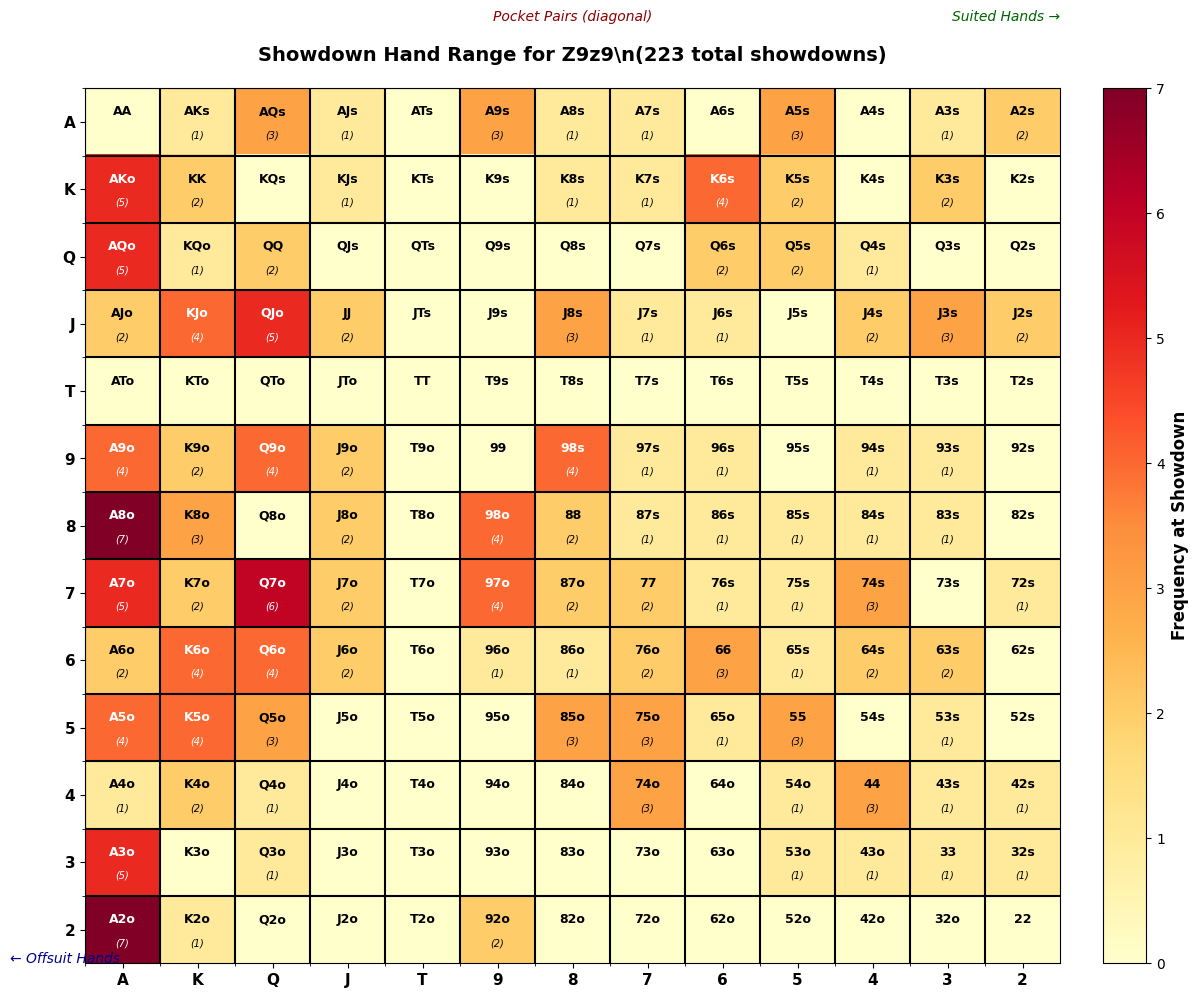


Most common showdown hands for Z9z9:
   1. A8o: 7 times
   2. A2o: 7 times
   3. Q7o: 6 times
   4. A7o: 5 times
   5. QJo: 5 times
   6. AQo: 5 times
   7. AKo: 5 times
   8. A3o: 5 times
   9. A9o: 4 times
   10. K6s: 4 times


In [18]:
# Visualize hand range for a specific player
def plot_hand_range_heatmap(player_name, player_range_data):
    """Create colorful heatmap of player's showdown range"""
    
    # Create frequency matrix
    freq_matrix = np.zeros((13, 13))
    
    for i, rank1 in enumerate(ranks):
        for j, rank2 in enumerate(ranks):
            hand = hand_matrix[i][j]
            freq_matrix[i][j] = player_range_data.get(hand, 0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create heatmap with custom colormap
    im = ax.imshow(freq_matrix, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(13))
    ax.set_yticks(np.arange(13))
    ax.set_xticklabels(ranks, fontsize=11, fontweight='bold')
    ax.set_yticklabels(ranks, fontsize=11, fontweight='bold')
    
    # Add grid
    ax.set_xticks(np.arange(13) - 0.5, minor=True)
    ax.set_yticks(np.arange(13) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1.5)
    
    # Add hand labels and frequencies
    for i in range(13):
        for j in range(13):
            hand = hand_matrix[i][j]
            freq = freq_matrix[i][j]
            
            # Determine text color based on background
            text_color = 'white' if freq > freq_matrix.max() * 0.5 else 'black'
            
            # Add hand notation
            ax.text(j, i - 0.15, hand, ha='center', va='center', 
                   fontsize=9, fontweight='bold', color=text_color)
            
            # Add frequency if > 0
            if freq > 0:
                ax.text(j, i + 0.2, f'({int(freq)})', ha='center', va='center',
                       fontsize=7, color=text_color, style='italic')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Frequency at Showdown', fontsize=12, fontweight='bold')
    
    # Title and labels
    total_showdowns = sum(player_range_data.values())
    ax.set_title(f'Showdown Hand Range for {player_name}\\n({total_showdowns} total showdowns)',
                fontsize=14, fontweight='bold', pad=20)
    
    # Add annotations
    ax.text(12.5, -1.5, 'Suited Hands →', fontsize=10, ha='right', style='italic', color='darkgreen')
    ax.text(-1.5, 12.5, '← Offsuit Hands', fontsize=10, ha='left', style='italic', color='darkblue')
    ax.text(6, -1.5, 'Pocket Pairs (diagonal)', fontsize=10, ha='center', style='italic', color='darkred')
    
    plt.tight_layout()
    plt.show()
    
    return freq_matrix

# Plot for most active player with showdown data
if player_ranges:
    # Find player with most showdowns
    players_with_showdowns = [(p, sum(hands.values())) for p, hands in player_ranges.items()]
    players_with_showdowns.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\nPlayers with showdown data:")
    for i, (player, count) in enumerate(players_with_showdowns[:5], 1):
        print(f"   {i}. {player}: {count} showdowns")
    
    # Plot for top player
    top_player = players_with_showdowns[0][0]
    print(f"\nGenerating range matrix for {top_player}...")
    
    freq_matrix = plot_hand_range_heatmap(top_player, player_ranges[top_player])
    
    # Show most common hands
    top_hands = sorted(player_ranges[top_player].items(), key=lambda x: x[1], reverse=True)[:10]
    print(f"\nMost common showdown hands for {top_player}:")
    for i, (hand, freq) in enumerate(top_hands, 1):
        print(f"   {i}. {hand}: {freq} times")
else:
    print("\nNo showdown data available for range analysis.")

### Generate Range Chart for Any Player

Generating range chart for: Justin


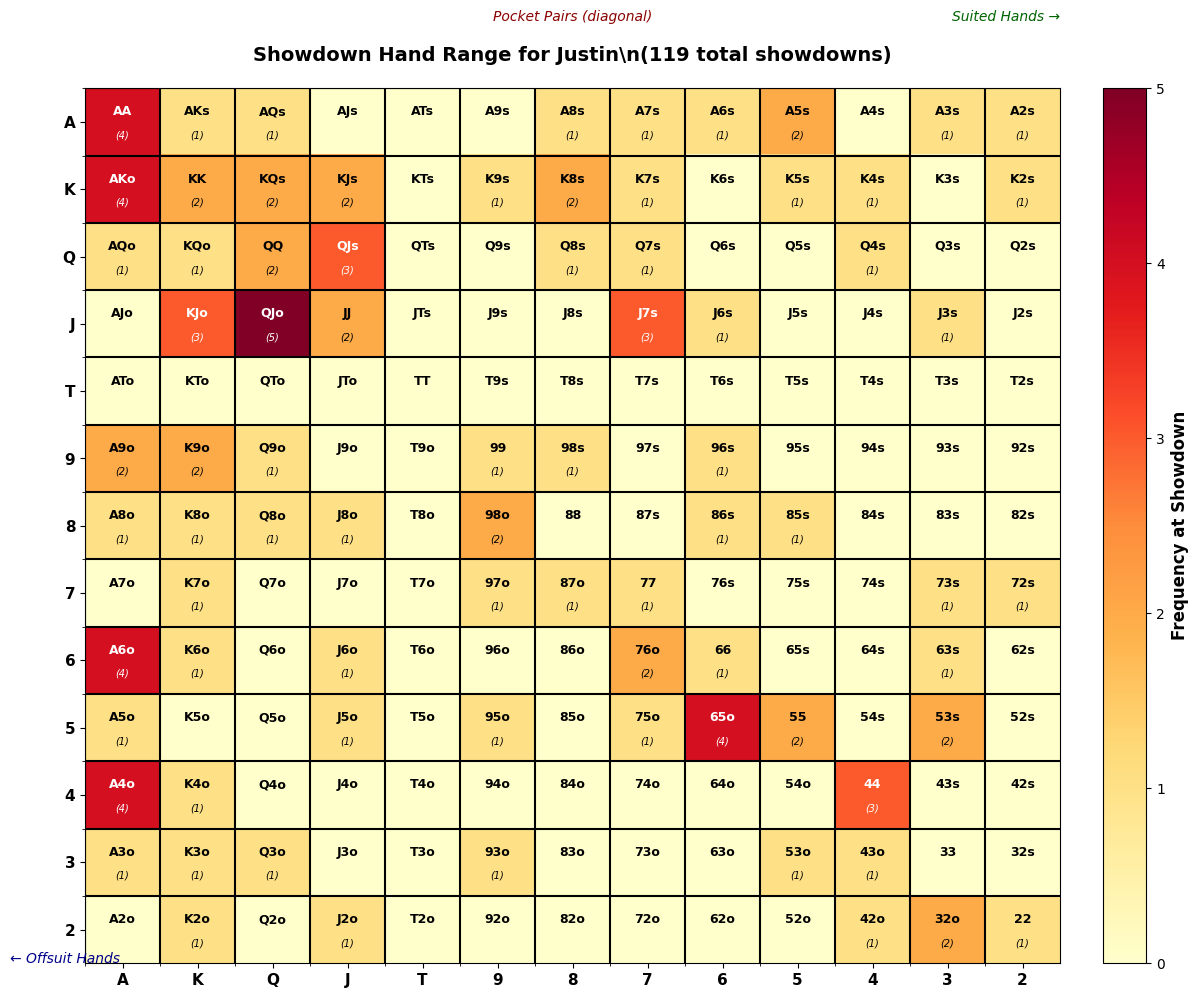


Top 15 showdown hands for Justin:
    1. QJo  - 5 times
    2. AKo  - 4 times
    3. A6o  - 4 times
    4. 65o  - 4 times
    5. AA   - 4 times
    6. A4o  - 4 times
    7. QJs  - 3 times
    8. 44   - 3 times
    9. KJo  - 3 times
   10. J7s  - 3 times
   11. K9o  - 2 times
   12. K8s  - 2 times
   13. JJ   - 2 times
   14. QQ   - 2 times
   15. 53s  - 2 times


In [20]:
# Generate range chart for a specific player
# EDIT THE PLAYER NAME BELOW:
selected_player = "Justin"  # Change this to any player name

if selected_player in player_ranges:
    print(f"Generating range chart for: {selected_player}")
    freq_matrix = plot_hand_range_heatmap(selected_player, player_ranges[selected_player])
    
    # Show top hands
    top_hands = sorted(player_ranges[selected_player].items(), key=lambda x: x[1], reverse=True)[:15]
    print(f"\nTop 15 showdown hands for {selected_player}:")
    for i, (hand, freq) in enumerate(top_hands, 1):
        print(f"   {i:2}. {hand:4} - {freq} times")
else:
    print(f"Player '{selected_player}' not found or has no showdown data.")
    print(f"\nAvailable players with showdown data:")
    for player in sorted(player_ranges.keys()):
        print(f"   • {player}")